In [1]:
import numpy as np
import pandas as pd
df_mode0=pd.read_csv('mode0_data.csv')
df_mode1=pd.read_csv('mode1_data.csv')
df=pd.concat([df_mode0,df_mode1],axis=0,join='outer')
data=pd.DataFrame()
data['add_time']=df['add_time']
data['Temperature']=df['Temperature']
data['Recation_time']=df['Recation_time']
data['mode']=df['mode']
data['Mn']=df['Mn']
data['pdi']=df['pdi']
data_index_new=np.arange(0,465)
data.index=data_index_new
data['Mn']=data['Mn']/1000
X=data.iloc[:,0:4]
X = (X-X.min())/(X.max()-X.min())
y=data.iloc[:,4:6]
data_normalize=pd.concat([X,y],axis=1,join='outer')

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.15,random_state=66)
kmeans=KMeans(n_clusters=5,random_state=50).fit(X_train)
centers = np.array(kmeans.cluster_centers_)

In [3]:
data_index_new1=np.arange(0,395)
X_train.index=data_index_new1
y_train.index=data_index_new1

In [4]:
from sklearn.metrics import pairwise_distances_argmin_min
closest, _ = pairwise_distances_argmin_min(centers, X_train)

In [5]:
data_inital=pd.concat([X_train.iloc[closest,],y_train.iloc[closest,]],axis=1,join='outer')

In [6]:
X_train_init=data_inital.iloc[:,0:4]
y_train_init=data_inital.iloc[:,4:6]

In [7]:
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.base import clone
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.utils import shuffle
from modAL.disagreement import max_std_sampling
from modAL.models import ActiveLearner, CommitteeRegressor
from modAL.uncertainty import entropy_sampling
from xgboost import XGBRegressor

In [8]:
def list_by_models(X,y):
    sklearn_list = [Ridge(), Lasso(), LinearRegression(),XGBRegressor(),RandomForestRegressor(n_estimators =50),RandomForestRegressor(n_estimators =100),KNeighborsRegressor(n_neighbors=2, weights='distance')]
    learner_list=[]
    for regressor_emcm in sklearn_list:
        learner=ActiveLearner(estimator=regressor_emcm, query_strategy=max_std_sampling, X_training=X, y_training=y)
        learner_list.append(learner)
    print(len(X))
    return learner_list

In [9]:
from numpy.linalg import norm
def expected_model_change_maximization(regressor, learner_list, X_pool, n_instances=1):
    changes = []
    for x in X_pool:
        x = x.reshape(1, -1)
        change = 0
        x_norm = norm(x)
        y_hat = regressor.predict(x)[0]
        for learner in learner_list:
            y_p = learner.predict(x)[0]
            change += abs(y_hat - y_p) * x_norm
            #change += abs(y_hat - y_p)
        change /= len(learner_list)
        changes.append(change)
    changes=np.squeeze(changes)
    #print(changes)
    changes_sum=changes.sum(axis=1)
    #print(changes_sum)
    query_idx = changes_sum.argsort()[-n_instances:][::-1]
    return query_idx

In [10]:
X_train_beiyong=X_train
y_train_beiyong=y_train

In [11]:
from sklearn import metrics
import warnings
warnings.filterwarnings("ignore")
# search_best_score_list=[]
# for j in range(1,150):
#     regressor=RandomForestRegressor(n_estimators=j,random_state=66)
#     regressor.fit(X_train_init, y_train_init)
#     test_score=regressor.score(X_test, y_test)
#     search_best_score_list.append(test_score)
# best_score_index=search_best_score_list.index(max(search_best_score_list))
# j_best=best_score_index+1
regressor=RandomForestRegressor(random_state=66)
regressor.fit(X_train_init, y_train_init)

RandomForestRegressor(random_state=66)

In [12]:
data_final=data_inital#Inital data_final
test_score_list=[]
mean_squared_error_list=[]
inital_y_predict=regressor.predict(X_test)
mean_squared_error_list.append(metrics.mean_squared_error(y_test,inital_y_predict))
print('inital mse',metrics.mean_squared_error(y_test,inital_y_predict))
for i in range(1,41):
    print(len(X_train))
    if i==1:
        learner_list=list_by_models(X=X_train_init,y=y_train_init)
    else:
        learner_list=list_by_models(X=X_train_relabel,y=y_train_relabel)
    re_idx=expected_model_change_maximization(regressor, learner_list, X_train.values, n_instances=1)
    data_relable=pd.concat([X_train.iloc[re_idx,],y_train.iloc[re_idx,]],axis=1,join='outer')
    X_train=X_train.drop(re_idx)
    y_train=y_train.drop(re_idx)
    X_train=X_train.reset_index(drop=True)
    y_train=y_train.reset_index(drop=True)
    #data_final=pd.concat([data_inital,data_relable],axis=0,join='outer')
    data_final=pd.concat([data_final,data_relable],axis=0,join='outer')#iteration to update data_final
    #print(data_final)
    X_train_relabel=data_final.iloc[:,0:4]
    y_train_relabel=data_final.iloc[:,4:6]
    #search_best_score_list=[]
    search_min_mse_list=[]
    for j in range(1,150):
        regressor=RandomForestRegressor(n_estimators=j,random_state=66)
        regressor.fit(X_train_relabel, y_train_relabel)
        #test_score=regressor.score(X_test, y_test)
        y_predict=regressor.predict(X_test)
        mse=metrics.mean_squared_error(y_test, y_predict)
        #search_best_score_list.append(test_score)
        search_min_mse_list.append(mse)
    #print( search_best_score_list)
    best_score_index=search_min_mse_list.index(min(search_min_mse_list))
    j_best=best_score_index+1
    regressor=RandomForestRegressor(n_estimators=j_best,random_state=66)
    regressor.fit(X_train_relabel, y_train_relabel)
    print("Testing Score:%f" % regressor.score(X_test, y_test))
    test_score_list.append(regressor.score(X_test, y_test))
    y_predict=regressor.predict(X_test)
    print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_predict))
    mean_squared_error_list.append(metrics.mean_squared_error(y_test, y_predict))

inital mse 8.710328113479488
395
5
Testing Score:0.234187
Mean Squared Error: 4.417390244291091
394
6
Testing Score:0.446595
Mean Squared Error: 2.6805247976406688
393
7
Testing Score:0.546818
Mean Squared Error: 2.0203180512861114
392
8
Testing Score:0.499485
Mean Squared Error: 1.6766023099894596
391
9
Testing Score:0.418262
Mean Squared Error: 1.5544389498409763
390
10
Testing Score:0.441989
Mean Squared Error: 1.1580399809945534
389
11
Testing Score:0.578788
Mean Squared Error: 1.1247868156962944
388
12
Testing Score:0.617458
Mean Squared Error: 1.107604307105625
387
13
Testing Score:0.541556
Mean Squared Error: 1.0337253994815967
386
14
Testing Score:0.595153
Mean Squared Error: 0.8312634052525001
385
15
Testing Score:0.623293
Mean Squared Error: 0.8452628279042762
384
16
Testing Score:0.679789
Mean Squared Error: 1.0035403942006456
383
17
Testing Score:0.723780
Mean Squared Error: 0.9649803120030064
382
18
Testing Score:0.727643
Mean Squared Error: 0.8906108126490135
381
19
Testi

In [13]:
diff1 = np.diff(mean_squared_error_list)
abs_diff1 = np.abs(diff1)
diff2 = np.diff(abs_diff1)
ASD = abs_diff1[1:] * np.abs(diff2)
mean_ASD_CMMC = np.mean(ASD)

In [14]:
mean_ASD_CMMC

0.1411249842140829

In [15]:
convergence_threshold = 0.1
loss_diffs = np.diff(mean_squared_error_list)
loss_diffs =np.abs(loss_diffs )
print(loss_diffs)

for i in range(0,40):
    if loss_diffs[i]<convergence_threshold and loss_diffs[i+1]<convergence_threshold and loss_diffs[i+2]<convergence_threshold:
        print(i)
        break

[4.29293787e+00 1.73686545e+00 6.60206746e-01 3.43715741e-01
 1.22163360e-01 3.96398969e-01 3.32531653e-02 1.71825086e-02
 7.38789076e-02 2.02461994e-01 1.39994227e-02 1.58277566e-01
 3.85600822e-02 7.43694994e-02 5.17570069e-02 2.27922721e-02
 1.22173471e-02 4.99944042e-02 1.63288550e-02 1.26922218e-01
 1.76965589e-01 8.96953141e-03 2.97621181e-02 1.56812770e-02
 1.86087661e-02 1.72161849e-02 2.90926814e-02 4.15386879e-03
 2.65468143e-02 4.31225139e-03 2.72664685e-03 3.89950579e-02
 1.16892818e-03 2.33462570e-02 1.11205510e-03 1.22132443e-03
 2.21986371e-02 8.51951428e-03 3.34053163e-03 1.44393942e-02]
6


In [16]:
import math
logMSE=[math.log(x)+1 for x in mean_squared_error_list]
logAUC_CMMC=np.sum(logMSE)
logAUC_CMMC

33.69351314142457

In [17]:
X_train_random=X_train_beiyong
y_train_random=y_train_beiyong

In [18]:
from sklearn import metrics
import random
import warnings
warnings.filterwarnings("ignore")
regressor=RandomForestRegressor(random_state=66)
regressor.fit(X_train_init, y_train_init)
#data_final=data_inital#Inital data_final
random_test_score_list=[]
random_mean_squared_error_list=[]
inital_y_predict=regressor.predict(X_test)
random_mean_squared_error_list.append(metrics.mean_squared_error(y_test,inital_y_predict))
for i in range(1,41):
    #re_idx=random.randint(0, len(X_train_random)-1)
    re_idx=random.sample(range(0, len(X_train_random)-1), i)
    print(re_idx)
    data_relable=pd.concat([X_train_random.iloc[re_idx,],y_train_random.iloc[re_idx,]],axis=1,join='outer')
    #X_train_random=X_train_random.drop(re_idx)
    #y_train_random=y_train_random.drop(re_idx)
    #X_train_random=X_train_random.reset_index(drop=True)
    #y_train_random=y_train_random.reset_index(drop=True)
    #data_final=pd.concat([data_inital,data_relable],axis=0,join='outer')
    #data_final=pd.concat([data_final,data_relable],axis=0,join='outer')#iteration to update data_final
    data_final=pd.concat([data_inital,data_relable],axis=0,join='outer')
    #print(data_final)
    X_train_relabel=data_final.iloc[:,0:4]
    y_train_relabel=data_final.iloc[:,4:6]
    #search_best_score_list=[]
    search_min_mse_list=[]
    for j in range(1,150):
        regressor=RandomForestRegressor(n_estimators=j,random_state=66)
        regressor.fit(X_train_relabel, y_train_relabel)
        #test_score=regressor.score(X_test, y_test)
        #search_best_score_list.append(test_score)
        y_predict=regressor.predict(X_test)
        mse=metrics.mean_squared_error(y_test, y_predict)
        search_min_mse_list.append(mse)   
    #print( search_best_score_list)
    #best_score_index=search_best_score_list.index(max(search_best_score_list))
    best_score_index=search_min_mse_list.index(min(search_min_mse_list))
    j_best=best_score_index+1
    regressor=RandomForestRegressor(n_estimators=j_best,random_state=66)
    regressor.fit(X_train_relabel, y_train_relabel)
    print("Testing Score:%f" % regressor.score(X_test, y_test))
    random_test_score_list.append(regressor.score(X_test, y_test))
    y_predict=regressor.predict(X_test)
    print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_predict))
    random_mean_squared_error_list.append(metrics.mean_squared_error(y_test, y_predict))

[129]
Testing Score:-0.055660
Mean Squared Error: 8.62352968102708
[179, 288]
Testing Score:0.406262
Mean Squared Error: 2.264080449003861
[159, 38, 226]
Testing Score:0.313483
Mean Squared Error: 1.9360055337135715
[154, 200, 276, 304]
Testing Score:0.427052
Mean Squared Error: 4.43741724568763
[34, 335, 240, 364, 207]
Testing Score:0.276941
Mean Squared Error: 1.7064397232934914
[50, 305, 191, 178, 288, 78]
Testing Score:0.592698
Mean Squared Error: 1.4907882485633523
[34, 92, 237, 90, 319, 386, 292]
Testing Score:0.485834
Mean Squared Error: 2.108494653185972
[133, 136, 171, 263, 201, 105, 48, 232]
Testing Score:0.604694
Mean Squared Error: 1.8635308713045584
[106, 330, 331, 189, 261, 98, 158, 132, 139]
Testing Score:0.581627
Mean Squared Error: 1.389698284481825
[77, 156, 318, 364, 87, 134, 229, 222, 128, 201]
Testing Score:0.714868
Mean Squared Error: 1.1836519428946604
[299, 325, 132, 2, 1, 297, 318, 366, 127, 108, 242]
Testing Score:0.626929
Mean Squared Error: 1.160076585693613

In [19]:
diff1_random = np.diff(random_mean_squared_error_list)
abs_diff1_random = np.abs(diff1_random)
diff2_random = np.diff(abs_diff1_random)
ASD_random = abs_diff1_random[1:] * np.abs(diff2_random)
mean_ASD_random = np.mean(ASD_random)
mean_ASD_random

1.3610423526380075

In [20]:
convergence_threshold = 0.1
loss_diffs_random = np.diff(random_mean_squared_error_list)
loss_diffs_random =np.abs(loss_diffs_random )
print(loss_diffs_random)

for i in range(0,39):
    if loss_diffs_random[i]<convergence_threshold and loss_diffs_random[i+1]<convergence_threshold and loss_diffs_random[i+2]<convergence_threshold:
        print(i)
        break

[8.67984325e-02 6.35944923e+00 3.28074915e-01 2.50141171e+00
 2.73097752e+00 2.15651475e-01 6.17706405e-01 2.44963782e-01
 4.73832587e-01 2.06046342e-01 2.35753572e-02 6.57269351e-01
 5.81005071e-01 2.84694159e-01 3.76649363e-01 6.91773010e-01
 3.01710616e-01 1.50376949e-01 1.96013641e-01 8.49291767e-01
 9.43616659e-01 1.01712701e+00 9.07065516e-01 4.95345757e-01
 2.93804855e-01 7.87020451e-01 6.83778329e-01 8.04374811e-01
 9.65010274e-01 1.31013675e-01 3.07996779e-01 8.24072551e-01
 7.72775447e-01 2.07282728e-03 1.03473060e-01 2.13255471e-01
 2.40711239e-02 8.15503585e-02 8.05570898e-01 1.56697761e-01]


In [21]:
logMSE_random=[math.log(x)+1 for x in random_mean_squared_error_list]
logAUC_random=np.sum(logMSE_random)
logAUC_random

48.19232186581123

In [22]:
X_train_qbc=X_train_beiyong
y_train_qbc=y_train_beiyong

In [23]:
from sklearn.metrics import pairwise_distances, pairwise_distances_argmin_min
def mse_uncertainty(regressor, Xtrain, ytrain, Xpool, n_instances=1):
    query_idx = []
    ypred = regressor.predict(Xtrain)
    se = (ytrain - ypred) ** 2
    distances = pairwise_distances(Xpool, Xtrain)
    uncertainty = np.sum(np.dot(1 / distances, se), axis=1) / np.sum(1 / distances, axis=1)
    for i in range(n_instances):
        current_idx = np.argmax(uncertainty)
        query_idx.append(current_idx)
        uncertainty[current_idx] = 0
    return query_idx

In [24]:
import warnings
warnings.filterwarnings("ignore")
data_final=data_inital#Inital data_final
regressor=RandomForestRegressor(random_state=66)
regressor.fit(X_train_init, y_train_init)
qbc_test_score_list=[]
qbc_mean_squared_error_list=[]
inital_y_predict=regressor.predict(X_test)
qbc_mean_squared_error_list.append(metrics.mean_squared_error(y_test,inital_y_predict))
for i in range(1,41):
    print(len(X_train_qbc))
    if i==1:
        X=X_train_init
        y=y_train_init
    else:
        X=X_train_relabel
        y=y_train_relabel
    re_idx=mse_uncertainty(regressor, X, y, X_train_qbc.values, n_instances=1)
    data_relable=pd.concat([X_train_qbc.iloc[re_idx,],y_train_qbc.iloc[re_idx,]],axis=1,join='outer')
    X_train_qbc=X_train_qbc.drop(re_idx)
    y_train_qbc=y_train_qbc.drop(re_idx)
    X_train_qbc=X_train_qbc.reset_index(drop=True)
    y_train_qbc=y_train_qbc.reset_index(drop=True)
    #data_final=pd.concat([data_inital,data_relable],axis=0,join='outer')
    data_final=pd.concat([data_final,data_relable],axis=0,join='outer')#iteration to update data_final
    #print(data_final)
    X_train_relabel=data_final.iloc[:,0:4]
    y_train_relabel=data_final.iloc[:,4:6]
    #search_best_score_list=[]
    search_min_mse_list=[]
    for j in range(1,150):
        regressor=RandomForestRegressor(n_estimators=j,random_state=66)
        regressor.fit(X_train_relabel, y_train_relabel)
        #test_score=regressor.score(X_test, y_test)
        y_predict=regressor.predict(X_test)
        mse=metrics.mean_squared_error(y_test, y_predict)
        #search_best_score_list.append(test_score)
        search_min_mse_list.append(mse)
    #print( search_best_score_list)
    best_score_index=search_min_mse_list.index(min(search_min_mse_list))
    j_best=best_score_index+1
    regressor=RandomForestRegressor(n_estimators=j_best,random_state=66)
    regressor.fit(X_train_relabel, y_train_relabel)
    print("Testing Score:%f" % regressor.score(X_test, y_test))
    qbc_test_score_list.append(regressor.score(X_test, y_test))
    y_predict=regressor.predict(X_test)
    print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_predict))
    qbc_mean_squared_error_list.append(metrics.mean_squared_error(y_test, y_predict))

395
Testing Score:-0.042965
Mean Squared Error: 8.259450140936355
394
Testing Score:-0.049955
Mean Squared Error: 8.345410622189144
393
Testing Score:-0.051857
Mean Squared Error: 8.433205473308826
392
Testing Score:-0.114537
Mean Squared Error: 8.031100668171428
391
Testing Score:-0.114537
Mean Squared Error: 8.031100668171428
390
Testing Score:-0.123529
Mean Squared Error: 8.012129368910358
389
Testing Score:-0.157673
Mean Squared Error: 7.667652281505714
388
Testing Score:-0.350438
Mean Squared Error: 8.33301058678286
387
Testing Score:-0.350438
Mean Squared Error: 8.33301058678286
386
Testing Score:0.351893
Mean Squared Error: 3.637421699051428
385
Testing Score:0.214570
Mean Squared Error: 5.4222145466132154
384
Testing Score:0.233205
Mean Squared Error: 5.354871755333574
383
Testing Score:0.250334
Mean Squared Error: 5.45020411016143
382
Testing Score:0.319189
Mean Squared Error: 4.250822199027144
381
Testing Score:0.326678
Mean Squared Error: 4.311108732421609
380
Testing Score:

In [25]:
diff1_qbc = np.diff(qbc_mean_squared_error_list)
abs_diff1_qbc = np.abs(diff1_qbc)
diff2_qbc = np.diff(abs_diff1_qbc)
ASD_qbc = abs_diff1_qbc[1:] * np.abs(diff2_qbc)
mean_ASD_qbc = np.mean(ASD_qbc)
mean_ASD_qbc

0.8571747529423829

In [26]:
convergence_threshold = 0.1
loss_diffs_qbc = np.diff(qbc_mean_squared_error_list)
loss_diffs_qbc =np.abs(loss_diffs_qbc )
print(loss_diffs_qbc)

for i in range(0,39):
    if loss_diffs_qbc[i]<convergence_threshold and loss_diffs_qbc[i+1]<convergence_threshold and loss_diffs_qbc[i+2]<convergence_threshold:
        print(i)
        break

[4.50877973e-01 8.59604813e-02 8.77948511e-02 4.02104805e-01
 0.00000000e+00 1.89712993e-02 3.44477087e-01 6.65358305e-01
 0.00000000e+00 4.69558889e+00 1.78479285e+00 6.73427913e-02
 9.53323548e-02 1.19938191e+00 6.02865334e-02 1.01737011e+00
 1.03397880e+00 1.35539598e+00 1.94994024e-01 1.52527949e-01
 1.27149667e-01 1.22738906e-01 1.06395619e-01 2.23113936e-02
 4.05878729e-02 1.56369291e+00 5.65592385e-02 8.24208731e-02
 2.80421899e-02 1.42676127e-02 1.31025561e-03 1.08216045e-01
 1.47942253e-01 5.18599184e-03 6.64919146e-02 4.33963106e-03
 8.36083527e-03 1.54767861e-01 1.25327091e-01 5.90379124e-02]
26


In [27]:
logMSE_qbc = [math.log(x) + 1 for x in qbc_mean_squared_error_list]
logAUC_qbc = np.sum(logMSE_qbc)
logAUC_qbc

88.05153632701908

In [28]:
X_train_udi=X_train_beiyong
y_train_udi=y_train_beiyong

In [29]:
from sklearn.linear_model import LogisticRegression
def discretization_uncertainty(classifier, X_train, y_train, X_pool, bins, n_instances=1):
    _, bins_edges = np.histogram(y_train, bins)
    d_y_train = np.digitize(y_train, bins_edges)
    #print(d_y_train)
    d_y_train=np.sum(d_y_train, axis=1, keepdims=True)
    #print(d_y_train)
    classifier = LogisticRegression()
    learner = ActiveLearner(estimator=classifier, query_strategy=entropy_sampling,
        X_training=X_train, y_training=d_y_train)
    query_idx, _ = learner.query(X_pool, n_instances)
    return query_idx

In [30]:
import warnings
warnings.filterwarnings("ignore")
data_final=data_inital#Inital data_final
regressor=RandomForestRegressor(random_state=66)
regressor.fit(X_train_init, y_train_init)
udi_test_score_list=[]
udi_mean_squared_error_list=[]
inital_y_predict=regressor.predict(X_test)
udi_mean_squared_error_list.append(metrics.mean_squared_error(y_test,inital_y_predict))
for i in range(1,41):
    print(len(X_train_udi))
    if i==1:
        X=X_train_init
        y=y_train_init
    else:
        X=X_train_relabel
        y=y_train_relabel
    re_idx=discretization_uncertainty(regressor,X, y, X_train_udi.values, bins=5,n_instances=1)
    data_relable=pd.concat([X_train_udi.iloc[re_idx,],y_train_udi.iloc[re_idx,]],axis=1,join='outer')
    X_train_udi=X_train_udi.drop(re_idx)
    y_train_udi=y_train_udi.drop(re_idx)
    X_train_udi=X_train_udi.reset_index(drop=True)
    y_train_udi=y_train_udi.reset_index(drop=True)
    #data_final=pd.concat([data_inital,data_relable],axis=0,join='outer')
    data_final=pd.concat([data_final,data_relable],axis=0,join='outer')#iteration to update data_final
    #print(data_final)
    X_train_relabel=data_final.iloc[:,0:4]
    y_train_relabel=data_final.iloc[:,4:6]
    #search_best_score_list=[]
    search_min_mse_list=[]
    for j in range(1,150):
        regressor=RandomForestRegressor(n_estimators=j,random_state=66)
        regressor.fit(X_train_relabel, y_train_relabel)
        #test_score=regressor.score(X_test, y_test)
        y_predict=regressor.predict(X_test)
        mse=metrics.mean_squared_error(y_test, y_predict)
        #search_best_score_list.append(test_score)
        search_min_mse_list.append(mse)
    #print( search_best_score_list)
    best_score_index=search_min_mse_list.index(min(search_min_mse_list))
    j_best=best_score_index+1
    regressor=RandomForestRegressor(n_estimators=j_best,random_state=66)
    regressor.fit(X_train_relabel, y_train_relabel)
    print("Testing Score:%f" % regressor.score(X_test, y_test))
    udi_test_score_list.append(regressor.score(X_test, y_test))
    y_predict=regressor.predict(X_test)
    print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_predict))
    udi_mean_squared_error_list.append(metrics.mean_squared_error(y_test, y_predict))

395
Testing Score:-0.064015
Mean Squared Error: 8.724102748713948
394
Testing Score:0.352409
Mean Squared Error: 3.0204349430058923
393
Testing Score:0.403034
Mean Squared Error: 2.355600836833617
392
Testing Score:0.477523
Mean Squared Error: 2.639166154763141
391
Testing Score:0.495583
Mean Squared Error: 2.486726340138413
390
Testing Score:0.570869
Mean Squared Error: 2.2448226009325403
389
Testing Score:0.524287
Mean Squared Error: 1.987016728760242
388
Testing Score:0.498656
Mean Squared Error: 2.5916823354650744
387
Testing Score:0.424790
Mean Squared Error: 2.5748079870333327
386
Testing Score:0.418725
Mean Squared Error: 2.563906286914312
385
Testing Score:0.348902
Mean Squared Error: 2.875974072194305
384
Testing Score:0.356696
Mean Squared Error: 2.7714172148507132
383
Testing Score:0.338480
Mean Squared Error: 2.953924436088623
382
Testing Score:0.350889
Mean Squared Error: 2.720246569022374
381
Testing Score:0.300884
Mean Squared Error: 2.8853075676015147
380
Testing Score:

In [31]:
diff1_udi = np.diff(udi_mean_squared_error_list)
abs_diff1_udi = np.abs(diff1_udi)
diff2_udi = np.diff(abs_diff1_udi)
ASD_udi = abs_diff1_udi[1:] * np.abs(diff2_udi)
mean_ASD_udi = np.mean(ASD_udi)
mean_ASD_udi

0.950698308341843

In [32]:
convergence_threshold = 0.1
loss_diffs_udi = np.diff(udi_mean_squared_error_list)
loss_diffs_udi = np.abs(loss_diffs_udi)
print(loss_diffs_udi)

for i in range(0,39):
    if loss_diffs_udi[i] < convergence_threshold and loss_diffs_udi[i+1] < convergence_threshold and loss_diffs_udi[i+2] < convergence_threshold:
        print(i)
        break

[1.37746352e-02 5.70366781e+00 6.64834106e-01 2.83565318e-01
 1.52439815e-01 2.41903739e-01 2.57805872e-01 6.04665607e-01
 1.68743484e-02 1.09017001e-02 3.12067785e-01 1.04556857e-01
 1.82507221e-01 2.33677867e-01 1.65060999e-01 5.12928818e-02
 3.28569551e-01 7.44008408e-04 1.85401293e-01 4.08543032e-02
 1.26766074e-01 3.27897869e-01 5.29091829e-01 2.37251012e-02
 1.99233681e-01 4.60753521e-02 6.98556939e-02 5.31753454e-02
 5.03576683e-02 9.46785167e-02 6.33802329e-01 3.72445812e-02
 2.83518957e-03 1.49880089e-02 2.73568546e-02 2.74039311e-02
 8.23578870e-03 5.04479034e-03 3.48637697e-03 3.34076621e-02]
25


In [33]:
logMSE_udi = [math.log(x) + 1 for x in udi_mean_squared_error_list]
logAUC_udi = np.sum(logMSE_udi)
logAUC_udi 

65.78045028875279

In [34]:
X_train_ucl=X_train_beiyong
y_train_ucl=y_train_beiyong

In [35]:
from sklearn.metrics import silhouette_samples
def cluster_uncertainty(regressor, X_pool, n_clusters, n_instances=1):
    query_idx = []
    kmeans = KMeans(n_clusters)
    y_pool = pd.DataFrame(np.sum(regressor.predict(X_pool), axis=1, keepdims=True), columns=['y'])
    kmeans.fit(X_pool)
    y_pool['cluster'] = kmeans.labels_
    y_pool['silhouette'] = silhouette_samples(y_pool['y'].to_numpy().reshape(-1, 1), y_pool['cluster'])
    selected_clusters = y_pool.groupby('cluster').agg({'y': 'var'}).nlargest(n_instances, 'y').index.tolist()
    for cluster in selected_clusters:
        query_idx.append(y_pool[y_pool['cluster'] == cluster]['silhouette'].idxmin())
    return query_idx

In [36]:
import warnings
warnings.filterwarnings("ignore")
data_final=data_inital#Inital data_final
regressor=RandomForestRegressor(random_state=66)
regressor.fit(X_train_init, y_train_init)
ucl_test_score_list=[]
ucl_mean_squared_error_list=[]
inital_y_predict=regressor.predict(X_test)
ucl_mean_squared_error_list.append(metrics.mean_squared_error(y_test,inital_y_predict))
for i in range(1,41):
    print(len(X_train_udi))
    if i==1:
        X=X_train_init
        y=y_train_init
    else:
        X=X_train_relabel
        y=y_train_relabel
    re_idx=cluster_uncertainty(regressor,X.values,n_clusters=3, n_instances=1)
    data_relable=pd.concat([X_train_ucl.iloc[re_idx,],y_train_ucl.iloc[re_idx,]],axis=1,join='outer')
    X_train_ucl=X_train_ucl.drop(re_idx)
    y_train_ucl=y_train_ucl.drop(re_idx)
    X_train_ucl=X_train_ucl.reset_index(drop=True)
    y_train_ucl=y_train_ucl.reset_index(drop=True)
    #data_final=pd.concat([data_inital,data_relable],axis=0,join='outer')
    data_final=pd.concat([data_final,data_relable],axis=0,join='outer')#iteration to update data_final
    #print(data_final)
    X_train_relabel=data_final.iloc[:,0:4]
    y_train_relabel=data_final.iloc[:,4:6]
    #search_best_score_list=[]
    search_min_mse_list=[]
    for j in range(1,150):
        regressor=RandomForestRegressor(n_estimators=j,random_state=66)
        regressor.fit(X_train_relabel, y_train_relabel)
        #test_score=regressor.score(X_test, y_test)
        y_predict=regressor.predict(X_test)
        mse=metrics.mean_squared_error(y_test, y_predict)
        #search_best_score_list.append(test_score)
        search_min_mse_list.append(mse)
    #print( search_best_score_list)
    best_score_index=search_min_mse_list.index(min(search_min_mse_list))
    j_best=best_score_index+1
    regressor=RandomForestRegressor(n_estimators=j_best,random_state=66)
    regressor.fit(X_train_relabel, y_train_relabel)
    print("Testing Score:%f" % regressor.score(X_test, y_test))
    ucl_test_score_list.append(regressor.score(X_test, y_test))
    y_predict=regressor.predict(X_test)
    print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_predict))
    ucl_mean_squared_error_list.append(metrics.mean_squared_error(y_test, y_predict))

355
Testing Score:-0.081100
Mean Squared Error: 8.784923632511559
355
Testing Score:-0.087825
Mean Squared Error: 8.908573336652834
355
Testing Score:0.092349
Mean Squared Error: 6.74087580671457
355
Testing Score:0.275136
Mean Squared Error: 3.634235340859242
355
Testing Score:0.189224
Mean Squared Error: 4.432693326090716
355
Testing Score:0.280687
Mean Squared Error: 4.258612895039316
355
Testing Score:0.261303
Mean Squared Error: 5.258632324168552
355
Testing Score:0.300297
Mean Squared Error: 3.6651401350133326
355
Testing Score:0.460523
Mean Squared Error: 3.765818339744127
355
Testing Score:0.386815
Mean Squared Error: 4.279803429770181
355
Testing Score:0.411855
Mean Squared Error: 3.7943974880963833
355
Testing Score:0.433874
Mean Squared Error: 4.044883597834948
355
Testing Score:0.533862
Mean Squared Error: 2.9486890041488443
355
Testing Score:0.548831
Mean Squared Error: 1.4496964653164726
355
Testing Score:0.556070
Mean Squared Error: 1.8411718727526527
355
Testing Score:0

In [37]:
diff1_ucl = np.diff(ucl_mean_squared_error_list)
abs_diff1_ucl = np.abs(diff1_ucl)
diff2_ucl = np.diff(abs_diff1_ucl)
ASD_ucl = abs_diff1_ucl[1:] * np.abs(diff2_ucl)
mean_ASD_ucl = np.mean(ASD_ucl)
mean_ASD_ucl

0.36321043525506364

In [38]:
convergence_threshold = 0.1
loss_diffs_ucl = np.diff(ucl_mean_squared_error_list)
loss_diffs_ucl = np.abs(loss_diffs_ucl)
print(loss_diffs_ucl)

for i in range(0,39):
    if loss_diffs_ucl[i] < convergence_threshold and loss_diffs_ucl[i+1] < convergence_threshold and loss_diffs_ucl[i+2] < convergence_threshold:
        print(i)
        break

[7.45955190e-02 1.23649704e-01 2.16769753e+00 3.10664047e+00
 7.98457985e-01 1.74080431e-01 1.00001943e+00 1.59349219e+00
 1.00678205e-01 5.13985090e-01 4.85405942e-01 2.50486110e-01
 1.09619459e+00 1.49899254e+00 3.91475407e-01 8.42113581e-01
 1.81370186e-01 2.05347908e-01 2.01155405e-03 1.20971846e-02
 1.91867919e-01 2.10146635e-02 7.17508299e-02 3.14472972e-02
 4.39622963e-02 3.11006462e-01 2.93160530e-02 9.36154518e-02
 5.62083407e-02 7.34006930e-02 9.15802755e-03 3.71629222e-02
 2.02527375e-02 2.26189407e-02 4.49514273e-02 4.30433853e-02
 3.73569648e-03 1.81761731e-01 2.14714429e-02 2.09248091e-03]
21


In [39]:
logMSE_ucl = [math.log(x) + 1 for x in ucl_mean_squared_error_list]
logAUC_ucl = np.sum(logMSE_ucl)
logAUC_ucl

58.03901322623691

In [79]:
method=['EMMC','Random','UMSE','UDi',"UCl"]
logAUC=[logAUC_CMMC,logAUC_random,logAUC_qbc,logAUC_udi ,logAUC_ucl]
ASD=[mean_ASD_CMMC,mean_ASD_random,mean_ASD_qbc,mean_ASD_udi,mean_ASD_ucl]
FTC=[6,40,26,25,21]

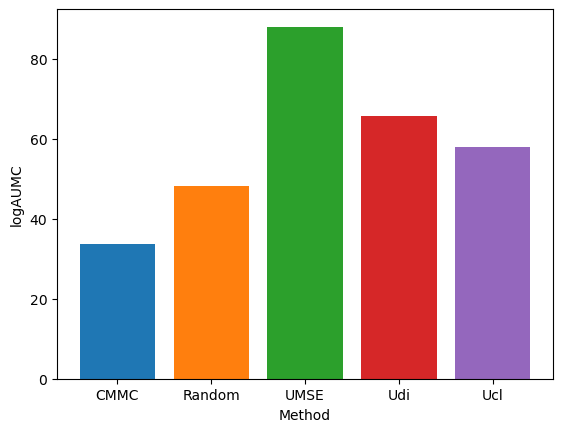

In [63]:
import matplotlib.pyplot as plt
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
plt.bar(method, logAUC,color=colors)
#plt.title('logAUC Comparison')
plt.xlabel('Method')
plt.ylabel('logAUMC')
plt.show()

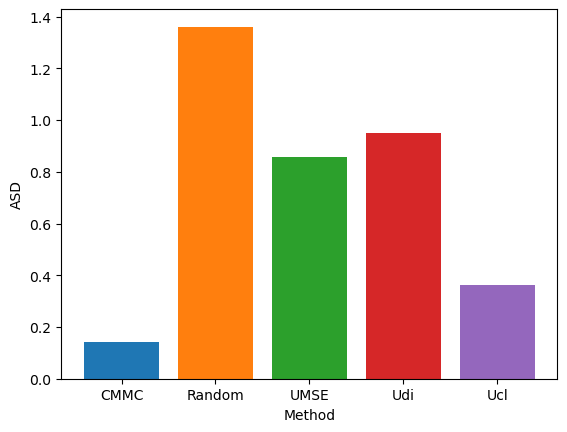

In [64]:
import matplotlib.pyplot as plt
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
plt.bar(method, ASD,color=colors)
#plt.title('ASD Comparison')
plt.xlabel('Method')
plt.ylabel('ASD')
plt.show()

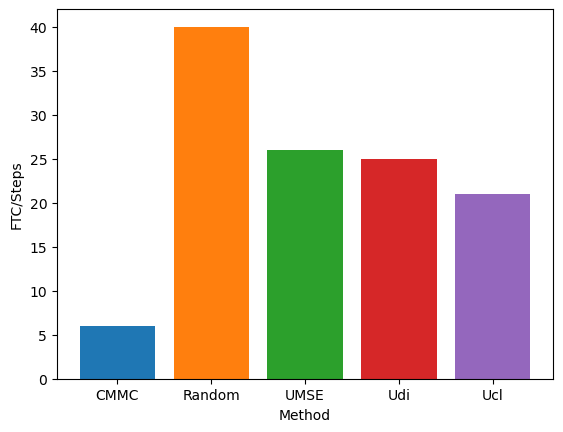

In [65]:
import matplotlib.pyplot as plt
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
plt.bar(method, FTC,color=colors)
#plt.title('FTC Comparison')
plt.xlabel('Method')
plt.ylabel('FTC/Steps')
plt.show()

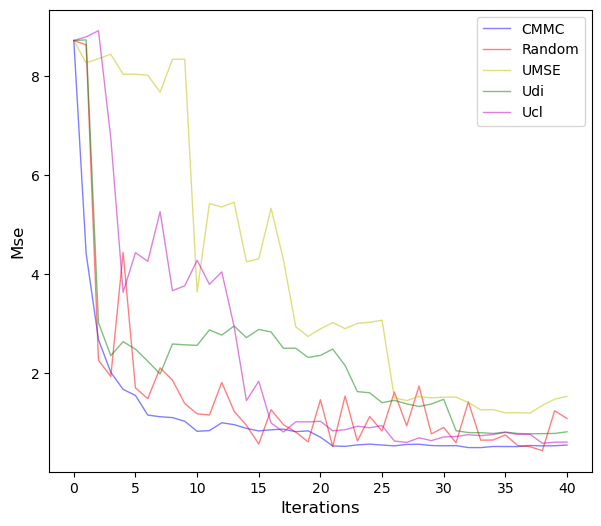

In [66]:
import matplotlib.pyplot as plt
number=np.arange(0,41)
fig, ax = plt.subplots(figsize=(7,6), dpi=100)
plt.plot(number, mean_squared_error_list, 'b-', alpha=0.5, linewidth=1, label='CMMC')
plt.plot(number, random_mean_squared_error_list, 'r-', alpha=0.5, linewidth=1, label='Random')
plt.plot(number, qbc_mean_squared_error_list, 'y-', alpha=0.5, linewidth=1, label='UMSE')
plt.plot(number, udi_mean_squared_error_list, 'g-', alpha=0.5, linewidth=1, label='Udi')
plt.plot(number, ucl_mean_squared_error_list, 'm-', alpha=0.5, linewidth=1, label='Ucl')
plt.legend()  #显示上面的label
plt.xlabel('Iterations', fontsize=12) #x_label
plt.ylabel('Mse',fontsize=12)#y_label

 
#plt.ylim(-1,1)#仅设置y轴坐标范围
plt.show()

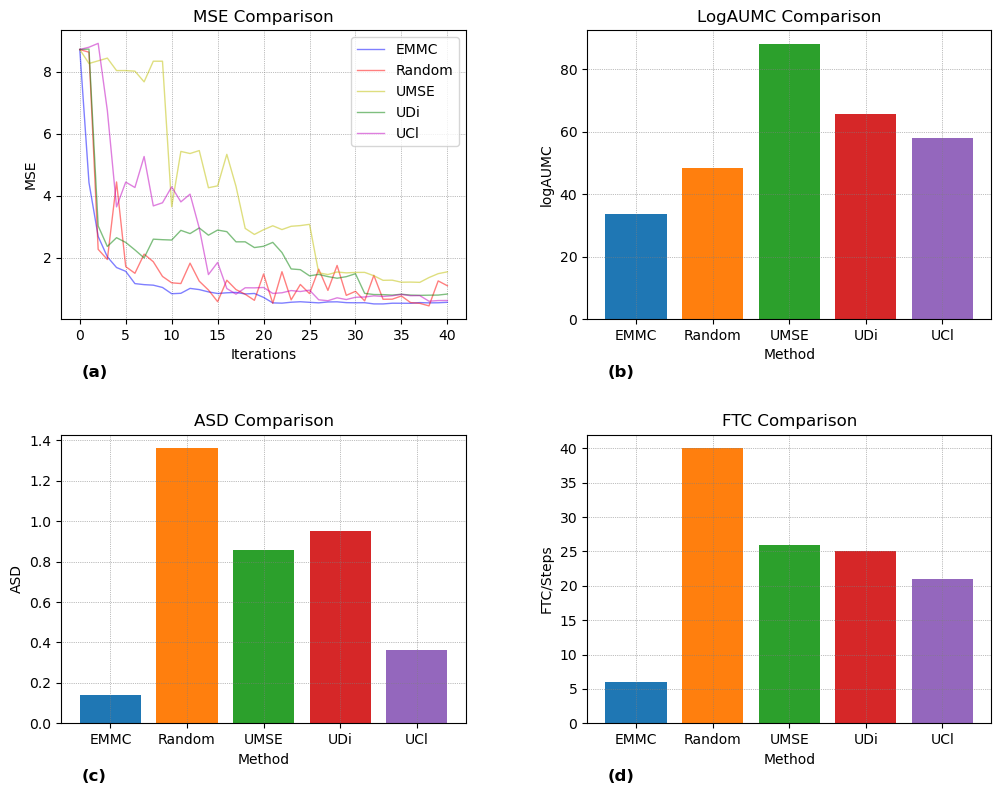

In [80]:
%matplotlib inline
import matplotlib.pyplot as plt

# 创建画布，设置子图大小和间距
fig = plt.figure(figsize=(12, 9))
gs = fig.add_gridspec(2, 2, hspace=0.4, wspace=0.3)

# 第1个子图
ax1 = fig.add_subplot(gs[0, 0])
number=np.arange(0,41)
ax1.plot(number, mean_squared_error_list, 'b-', alpha=0.5, linewidth=1, label='EMMC')
ax1.plot(number, random_mean_squared_error_list, 'r-', alpha=0.5, linewidth=1, label='Random')
ax1.plot(number, qbc_mean_squared_error_list, 'y-', alpha=0.5, linewidth=1, label='UMSE')
ax1.plot(number, udi_mean_squared_error_list, 'g-', alpha=0.5, linewidth=1, label='UDi')
ax1.plot(number, ucl_mean_squared_error_list, 'm-', alpha=0.5, linewidth=1, label='UCl')
ax1.legend()  #显示上面的label
ax1.set_xlabel('Iterations') #x_label
ax1.set_ylabel('MSE')#y_label
ax1.set_title('MSE Comparison')
ax1.text(0.05, -0.2, "(a)", transform=ax1.transAxes, fontweight="bold", fontsize=12)

# 第2个子图
ax2 = fig.add_subplot(gs[0, 1])
ax2.bar(method, logAUC, color=colors)
ax2.set_xlabel('Method')
ax2.set_ylabel('logAUMC')
ax2.set_title('LogAUMC Comparison')
ax2.text(0.05, -0.2, "(b)", transform=ax2.transAxes, fontweight="bold", fontsize=12)

# 第3个子图
ax3 = fig.add_subplot(gs[1, 0])
ax3.bar(method, ASD, color=colors)
ax3.set_xlabel('Method')
ax3.set_ylabel('ASD')
ax3.set_title('ASD Comparison')
ax3.text(0.05, -0.2, "(c)", transform=ax3.transAxes, fontweight="bold", fontsize=12)

# 第4个子图
ax4 = fig.add_subplot(gs[1, 1])
ax4.bar(method, FTC, color=colors)
ax4.set_xlabel('Method')
ax4.set_ylabel('FTC/Steps')
ax4.set_title('FTC Comparison')
ax4.text(0.05, -0.2, "(d)", transform=ax4.transAxes, fontweight="bold", fontsize=12)



# 设置所有子图的网格线
for ax in [ax1, ax2, ax3, ax4]:
    ax.grid(color='gray', linestyle=':', linewidth=0.5)

# 显示所有子图
plt.show()


In [73]:
mean_squared_error_list[0:45:5]

[8.710328113479488,
 1.5544389498409763,
 0.8312634052525001,
 0.8388538057150472,
 0.7132756581195429,
 0.5541751665908183,
 0.5393464662024625,
 0.524143328844229,
 0.554381053042839]

In [75]:
random_mean_squared_error_list[0:45:5]

[8.710328113479488,
 1.7064397232934914,
 1.1836519428946604,
 0.5749973432911561,
 1.4679609151180308,
 0.8359466511958946,
 0.909566984569661,
 0.7584131966616923,
 1.0884093804243975]

In [76]:
qbc_mean_squared_error_list[0:45:5]

[8.710328113479488,
 8.031100668171428,
 3.637421699051428,
 4.311108732421609,
 2.896637984136944,
 3.070343631089983,
 1.5187377742143335,
 1.202583808927233,
 1.5376954691672569]

In [77]:
udi_mean_squared_error_list[0:45:5]

[8.710328113479488,
 2.486726340138413,
 2.563906286914312,
 2.8853075676015147,
 2.3616421532178578,
 1.4084597474633522,
 1.4765402453519245,
 0.8150269909916945,
 0.8213261006319772]

In [78]:
ucl_mean_squared_error_list[0:45:5]

[8.710328113479488,
 4.432693326090716,
 4.279803429770181,
 1.8411718727526527,
 1.0331216443511433,
 0.9465342178537692,
 0.7170195065717463,
 0.8106580867979047,
 0.6131525905762583]

In [46]:
X_train_L1=X_train_beiyong
y_train_L1=y_train_beiyong

In [47]:
data_final=data_inital
regressor=Lasso(alpha=0.1,random_state=66)
regressor.fit(X_train_init, y_train_init)
L1_test_score_list=[]
L1_mean_squared_error_list=[]
L1_inital_y_predict=regressor.predict(X_test)
L1_mean_squared_error_list.append(metrics.mean_squared_error(y_test,inital_y_predict))
print('inital mse',metrics.mean_squared_error(y_test,inital_y_predict))
for i in range(1,41):
    print(len(X_train_L1))
    if i==1:
        learner_list=list_by_models(X=X_train_init,y=y_train_init)
    else:
        learner_list=list_by_models(X=X_train_relabel,y=y_train_relabel)
    re_idx=expected_model_change_maximization(regressor, learner_list, X_train_L1.values, n_instances=1)
    data_relable=pd.concat([X_train_L1.iloc[re_idx,],y_train_L1.iloc[re_idx,]],axis=1,join='outer')
    X_train_L1=X_train_L1.drop(re_idx)
    y_train_L1=y_train_L1.drop(re_idx)
    X_train_L1=X_train_L1.reset_index(drop=True)
    y_train_L1=y_train_L1.reset_index(drop=True)
    #data_final=pd.concat([data_inital,data_relable],axis=0,join='outer')
    data_final=pd.concat([data_final,data_relable],axis=0,join='outer')#iteration to update data_final
    #print(data_final)
    X_train_relabel=data_final.iloc[:,0:4]
    y_train_relabel=data_final.iloc[:,4:6]
    search_min_mse_list=[]
    for j in range(1,20):
        regressor=Lasso(alpha=j/10,random_state=66)
        regressor.fit(X_train_relabel, y_train_relabel)
        #test_score=regressor.score(X_test, y_test)
        y_predict=regressor.predict(X_test)
        mse=metrics.mean_squared_error(y_test, y_predict)
        #search_best_score_list.append(test_score)
        search_min_mse_list.append(mse)
    #print( search_best_score_list)
    best_score_index=search_min_mse_list.index(min(search_min_mse_list))
    j_best=(best_score_index+1)/10
    regressor=Lasso(alpha=j_best,random_state=66)
    regressor.fit(X_train_relabel, y_train_relabel)
    print("Testing Score:%f" % regressor.score(X_test, y_test))
    L1_test_score_list.append(regressor.score(X_test, y_test))
    y_predict=regressor.predict(X_test)
    print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_predict))
    L1_mean_squared_error_list.append(metrics.mean_squared_error(y_test, y_predict))

inital mse 8.710328113479488
395
5
Testing Score:-0.050973
Mean Squared Error: 9.348907517141118
394
6
Testing Score:-0.004599
Mean Squared Error: 9.456481891093608
393
7
Testing Score:0.347069
Mean Squared Error: 3.8718825956935987
392
8
Testing Score:0.359439
Mean Squared Error: 3.2628322388394424
391
9
Testing Score:0.353268
Mean Squared Error: 2.975771419667014
390
10
Testing Score:0.343937
Mean Squared Error: 2.9849694815388323
389
11
Testing Score:0.340188
Mean Squared Error: 2.6569964726779864
388
12
Testing Score:0.326528
Mean Squared Error: 2.6498672783891846
387
13
Testing Score:0.458078
Mean Squared Error: 1.8216941804285667
386
14
Testing Score:0.374345
Mean Squared Error: 1.9271190650135543
385
15
Testing Score:0.337356
Mean Squared Error: 1.9397298384905168
384
16
Testing Score:0.327255
Mean Squared Error: 1.9586887450484285
383
17
Testing Score:0.381575
Mean Squared Error: 1.928994436293429
382
18
Testing Score:0.480290
Mean Squared Error: 1.9044080080593644
381
19
Testi

In [48]:
diff1_L1 = np.diff(L1_mean_squared_error_list)
abs_diff1_L1 = np.abs(diff1_L1)
diff2_L1 = np.diff(abs_diff1_L1)
ASD_L1 = abs_diff1_L1[1:] * np.abs(diff2_L1)
mean_ASD_L1 = np.mean(ASD_L1)
print('mean_ASD_L1 is',mean_ASD_L1)

convergence_threshold = 0.1
loss_diffs_L1 = np.diff(L1_mean_squared_error_list)
loss_diffs_L1 = np.abs(loss_diffs_L1)

for i in range(0,39):
    if loss_diffs_L1[i]<convergence_threshold and loss_diffs_L1[i+1]<convergence_threshold and loss_diffs_L1[i+2]<convergence_threshold:
        print(i)
        break

logMSE_L1=[math.log(x)+1 for x in L1_mean_squared_error_list]
logAUC_L1=np.sum(logMSE_L1)
print('logAUC_L1 is ',logAUC_L1)

mean_ASD_L1 is 0.8907270235296019
10
logAUC_L1 is  74.97924739879825


In [49]:
X_train_L2=X_train_beiyong
y_train_L2=y_train_beiyong

In [50]:
data_final=data_inital
regressor=Ridge(alpha=0.1,random_state=66)
regressor.fit(X_train_init, y_train_init)
L2_test_score_list=[]
L2_mean_squared_error_list=[]
L2_inital_y_predict=regressor.predict(X_test)
L2_mean_squared_error_list.append(metrics.mean_squared_error(y_test,inital_y_predict))
print('inital mse',metrics.mean_squared_error(y_test,inital_y_predict))
for i in range(1,41):
    print(len(X_train_L2))
    if i==1:
        learner_list=list_by_models(X=X_train_init,y=y_train_init)
    else:
        learner_list=list_by_models(X=X_train_relabel,y=y_train_relabel)
    re_idx=expected_model_change_maximization(regressor, learner_list, X_train_L2.values, n_instances=1)
    data_relable=pd.concat([X_train_L2.iloc[re_idx,],y_train_L2.iloc[re_idx,]],axis=1,join='outer')
    X_train_L2=X_train_L2.drop(re_idx)
    y_train_L2=y_train_L2.drop(re_idx)
    X_train_L2=X_train_L2.reset_index(drop=True)
    y_train_L2=y_train_L2.reset_index(drop=True)
    #data_final=pd.concat([data_inital,data_relable],axis=0,join='outer')
    data_final=pd.concat([data_final,data_relable],axis=0,join='outer')#iteration to update data_final
    #print(data_final)
    X_train_relabel=data_final.iloc[:,0:4]
    y_train_relabel=data_final.iloc[:,4:6]
    search_min_mse_list=[]
    for j in range(1,20):
        regressor=Ridge(alpha=j/10,random_state=66)
        regressor.fit(X_train_relabel, y_train_relabel)
        #test_score=regressor.score(X_test, y_test)
        y_predict=regressor.predict(X_test)
        mse=metrics.mean_squared_error(y_test, y_predict)
        #search_best_score_list.append(test_score)
        search_min_mse_list.append(mse)
    #print( search_best_score_list)
    best_score_index=search_min_mse_list.index(min(search_min_mse_list))
    j_best=(best_score_index+1)/10
    regressor=Ridge(alpha=j_best,random_state=66)
    regressor.fit(X_train_relabel, y_train_relabel)
    print("Testing Score:%f" % regressor.score(X_test, y_test))
    L2_test_score_list.append(regressor.score(X_test, y_test))
    y_predict=regressor.predict(X_test)
    print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_predict))
    L2_mean_squared_error_list.append(metrics.mean_squared_error(y_test, y_predict))

inital mse 8.710328113479488
395
5
Testing Score:-0.030619
Mean Squared Error: 8.58951694123708
394
6
Testing Score:-0.002251
Mean Squared Error: 8.249086724692374
393
7
Testing Score:0.399104
Mean Squared Error: 4.395793571733769
392
8
Testing Score:0.505954
Mean Squared Error: 3.012155427373489
391
9
Testing Score:0.468184
Mean Squared Error: 2.874246978917162
390
10
Testing Score:0.472856
Mean Squared Error: 2.8909684139578
389
11
Testing Score:0.491932
Mean Squared Error: 2.655767602851344
388
12
Testing Score:0.518375
Mean Squared Error: 2.366372188285261
387
13
Testing Score:0.563282
Mean Squared Error: 1.8746631669009703
386
14
Testing Score:0.579490
Mean Squared Error: 1.7233995586233295
385
15
Testing Score:0.568881
Mean Squared Error: 1.8791550357422757
384
16
Testing Score:0.571264
Mean Squared Error: 1.850484278612688
383
17
Testing Score:0.578217
Mean Squared Error: 1.768123647534294
382
18
Testing Score:0.571156
Mean Squared Error: 1.8446315272852993
381
19
Testing Score:

In [51]:
diff1_L2 = np.diff(L2_mean_squared_error_list)
abs_diff1_L2 = np.abs(diff1_L2)
diff2_L2 = np.diff(abs_diff1_L2)
ASD_L2 = abs_diff1_L2[1:] * np.abs(diff2_L2)
mean_ASD_L2 = np.mean(ASD_L2)
print('mean_ASD_L2 is',mean_ASD_L2)

convergence_threshold = 0.1
loss_diffs_L2 = np.diff(L2_mean_squared_error_list)
loss_diffs_L2 = np.abs(loss_diffs_L2)

for i in range(0,39):
    if loss_diffs_L2[i]<convergence_threshold and loss_diffs_L2[i+1]<convergence_threshold and loss_diffs_L2[i+2]<convergence_threshold:
        print(i)
        break

logMSE_L2=[math.log(x)+1 for x in L2_mean_squared_error_list]
logAUC_L2=np.sum(logMSE_L2)
print('logAUC_L2 is ',logAUC_L2)

mean_ASD_L2 is 0.4541366123448421
11
logAUC_L2 is  71.5857673470058


In [52]:
X_train_KN=X_train_beiyong
y_train_KN=y_train_beiyong

In [53]:
data_final=data_inital
regressor=KNeighborsRegressor(n_neighbors=2, weights='distance')
regressor.fit(X_train_init, y_train_init)
KN_test_score_list=[]
KN_mean_squared_error_list=[]
KN_inital_y_predict=regressor.predict(X_test)
KN_mean_squared_error_list.append(metrics.mean_squared_error(y_test,inital_y_predict))
print('inital mse',metrics.mean_squared_error(y_test,inital_y_predict))
for i in range(1,41):
    print(len(X_train_KN))
    if i==1:
        learner_list=list_by_models(X=X_train_init,y=y_train_init)
    else:
        learner_list=list_by_models(X=X_train_relabel,y=y_train_relabel)
    re_idx=expected_model_change_maximization(regressor, learner_list, X_train_KN.values, n_instances=1)
    data_relable=pd.concat([X_train_KN.iloc[re_idx,],y_train_KN.iloc[re_idx,]],axis=1,join='outer')
    X_train_KN=X_train_KN.drop(re_idx)
    y_train_KN=y_train_KN.drop(re_idx)
    X_train_KN=X_train_KN.reset_index(drop=True)
    y_train_KN=y_train_KN.reset_index(drop=True)
    #data_final=pd.concat([data_inital,data_relable],axis=0,join='outer')
    data_final=pd.concat([data_final,data_relable],axis=0,join='outer')#iteration to update data_final
    #print(data_final)
    X_train_relabel=data_final.iloc[:,0:4]
    y_train_relabel=data_final.iloc[:,4:6]
    search_min_mse_list=[]
    for j in range(1,5):
        regressor=KNeighborsRegressor(n_neighbors=j, weights='distance')
        regressor.fit(X_train_relabel, y_train_relabel)
        #test_score=regressor.score(X_test, y_test)
        y_predict=regressor.predict(X_test)
        mse=metrics.mean_squared_error(y_test, y_predict)
        #search_best_score_list.append(test_score)
        search_min_mse_list.append(mse)
    #print( search_best_score_list)
    best_score_index=search_min_mse_list.index(min(search_min_mse_list))
    j_best=best_score_index+1
    regressor=KNeighborsRegressor(n_neighbors=j_best, weights='distance')
    regressor.fit(X_train_relabel, y_train_relabel)
    print("Testing Score:%f" % regressor.score(X_test, y_test))
    KN_test_score_list.append(regressor.score(X_test, y_test))
    y_predict=regressor.predict(X_test)
    print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_predict))
    KN_mean_squared_error_list.append(metrics.mean_squared_error(y_test, y_predict))

inital mse 8.710328113479488
395
5
Testing Score:-0.102510
Mean Squared Error: 8.833316218456428
394
6
Testing Score:-0.109457
Mean Squared Error: 8.74182271178714
393
7
Testing Score:0.206830
Mean Squared Error: 6.942602442384111
392
8
Testing Score:0.302273
Mean Squared Error: 5.717482895858662
391
9
Testing Score:0.290170
Mean Squared Error: 5.70543081619134
390
10
Testing Score:0.292212
Mean Squared Error: 5.624308500200986
389
11
Testing Score:0.355110
Mean Squared Error: 4.297231568071802
388
12
Testing Score:0.373939
Mean Squared Error: 4.0738606107075235
387
13
Testing Score:0.433437
Mean Squared Error: 2.794371070650474
386
14
Testing Score:0.491416
Mean Squared Error: 2.722595161363925
385
15
Testing Score:0.507035
Mean Squared Error: 2.629022198533953
384
16
Testing Score:0.547592
Mean Squared Error: 2.503910008238157
383
17
Testing Score:0.546318
Mean Squared Error: 2.588709366391958
382
18
Testing Score:0.515028
Mean Squared Error: 2.7211493390044037
381
19
Testing Score:0

In [54]:
diff1_KN = np.diff(KN_mean_squared_error_list)
abs_diff1_KN = np.abs(diff1_KN)
diff2_KN = np.diff(abs_diff1_KN)
ASD_KN = abs_diff1_KN[1:] * np.abs(diff2_KN)
mean_ASD_KN = np.mean(ASD_KN)
print('mean_ASD_KN is',mean_ASD_KN)

convergence_threshold = 0.1
loss_diffs_KN = np.diff(KN_mean_squared_error_list)
loss_diffs_KN = np.abs(loss_diffs_KN)

for i in range(0,39):
    if loss_diffs_KN[i]<convergence_threshold and loss_diffs_KN[i+1]<convergence_threshold and loss_diffs_KN[i+2]<convergence_threshold:
        print(i)
        break

logMSE_KN=[math.log(x)+1 for x in KN_mean_squared_error_list]
logAUC_KN=np.sum(logMSE_KN)
print('logAUC_KN is ',logAUC_KN)

mean_ASD_KN is 0.19400064596598332
14
logAUC_KN is  84.06361354867096


In [55]:
X_train_xgb=X_train_beiyong
y_train_xgb=y_train_beiyong

In [56]:
data_final=data_inital
regressor=XGBRegressor(n_estimators = 20, 
                   learning_rate = 0.05, 
                   max_depth=5)
regressor.fit(X_train_init, y_train_init)
xgb_test_score_list=[]
xgb_mean_squared_error_list=[]
xgb_inital_y_predict=regressor.predict(X_test)
xgb_mean_squared_error_list.append(metrics.mean_squared_error(y_test,inital_y_predict))
print('inital mse',metrics.mean_squared_error(y_test,inital_y_predict))
for i in range(1,41):
    #print(len(X_train_KN))
    if i==1:
        learner_list=list_by_models(X=X_train_init,y=y_train_init)
    else:
        learner_list=list_by_models(X=X_train_relabel,y=y_train_relabel)
    re_idx=expected_model_change_maximization(regressor, learner_list, X_train_xgb.values, n_instances=1)
    data_relable=pd.concat([X_train_xgb.iloc[re_idx,],y_train_xgb.iloc[re_idx,]],axis=1,join='outer')
    X_train_xgb=X_train_xgb.drop(re_idx)
    y_train_xgb=y_train_xgb.drop(re_idx)
    X_train_xgb=X_train_xgb.reset_index(drop=True)
    y_train_xgb=y_train_xgb.reset_index(drop=True)
    #data_final=pd.concat([data_inital,data_relable],axis=0,join='outer')
    data_final=pd.concat([data_final,data_relable],axis=0,join='outer')#iteration to update data_final
    #print(data_final)
    X_train_relabel=data_final.iloc[:,0:4]
    y_train_relabel=data_final.iloc[:,4:6]
    search_min_mse_list=[]
    for j in range(1,50):
        regressor=XGBRegressor(n_estimators = j, 
                   learning_rate = 0.05, 
                   max_depth=5)
        regressor.fit(X_train_relabel, y_train_relabel)
        #test_score=regressor.score(X_test, y_test)
        y_predict=regressor.predict(X_test)
        mse=metrics.mean_squared_error(y_test, y_predict)
        #search_best_score_list.append(test_score)
        search_min_mse_list.append(mse)
    #print( search_best_score_list)
    best_score_index=search_min_mse_list.index(min(search_min_mse_list))
    j_best=best_score_index+1
    regressor=XGBRegressor(n_estimators = j_best, 
                   learning_rate = 0.1, 
                   max_depth=5)
    regressor.fit(X_train_relabel, y_train_relabel)
    print("Testing Score:%f" % regressor.score(X_test, y_test))
    xgb_test_score_list.append(regressor.score(X_test, y_test))
    y_predict=regressor.predict(X_test)
    print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_predict))
    xgb_mean_squared_error_list.append(metrics.mean_squared_error(y_test, y_predict))

inital mse 8.710328113479488
5
Testing Score:-0.397708
Mean Squared Error: 8.313137303429622
6
Testing Score:-0.190867
Mean Squared Error: 8.22281396051737
7
Testing Score:-0.028023
Mean Squared Error: 8.440747416681498
8
Testing Score:0.015395
Mean Squared Error: 8.423571388536642
9
Testing Score:0.138723
Mean Squared Error: 7.501166186015387
10
Testing Score:0.562202
Mean Squared Error: 2.8915811796435484
11
Testing Score:0.566702
Mean Squared Error: 2.8244818237296743
12
Testing Score:0.672327
Mean Squared Error: 1.4209461586292744
13
Testing Score:0.690221
Mean Squared Error: 1.4998534272920756
14
Testing Score:0.695310
Mean Squared Error: 1.660295669396992
15
Testing Score:0.695088
Mean Squared Error: 1.7077839144681006
16
Testing Score:0.755156
Mean Squared Error: 1.1216367216362928
17
Testing Score:0.776258
Mean Squared Error: 0.9392857900721516
18
Testing Score:0.772168
Mean Squared Error: 1.005397212492632
19
Testing Score:0.747319
Mean Squared Error: 1.2534127506919235
20
Tes

In [57]:
diff1_xgb = np.diff(xgb_mean_squared_error_list)
abs_diff1_xgb = np.abs(diff1_xgb)
diff2_xgb = np.diff(abs_diff1_xgb)
ASD_xgb = abs_diff1_xgb[1:] * np.abs(diff2_xgb)
mean_ASD_xgb = np.mean(ASD_xgb)
print('mean_ASD_xgb is',mean_ASD_xgb)

convergence_threshold = 0.1
loss_diffs_xgb = np.diff(xgb_mean_squared_error_list)
loss_diffs_xgb = np.abs(loss_diffs_xgb)

for i in range(0,39):
    if loss_diffs_xgb[i]<convergence_threshold and loss_diffs_xgb[i+1]<convergence_threshold and loss_diffs_xgb[i+2]<convergence_threshold:
        print(i)
        break

logMSE_xgb=[math.log(x)+1 for x in xgb_mean_squared_error_list]
logAUC_xgb=np.sum(logMSE_xgb)
print('logAUC_xgb is ',logAUC_xgb)

mean_ASD_xgb is 0.5328296862513024
15
logAUC_xgb is  56.29962195312337


In [70]:
method_reg=['Random Forest','LASSO','Ridge','KNeighbors',"Xgboost"]
logAUC_reg=[logAUC_CMMC,logAUC_L1,logAUC_L2,logAUC_KN,logAUC_xgb]
ASD_reg=[mean_ASD_CMMC,mean_ASD_L1,mean_ASD_L2,mean_ASD_KN,mean_ASD_xgb]
FTC_reg=[6,10,11,14,15]

In [71]:
import matplotlib.pyplot as plt
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']

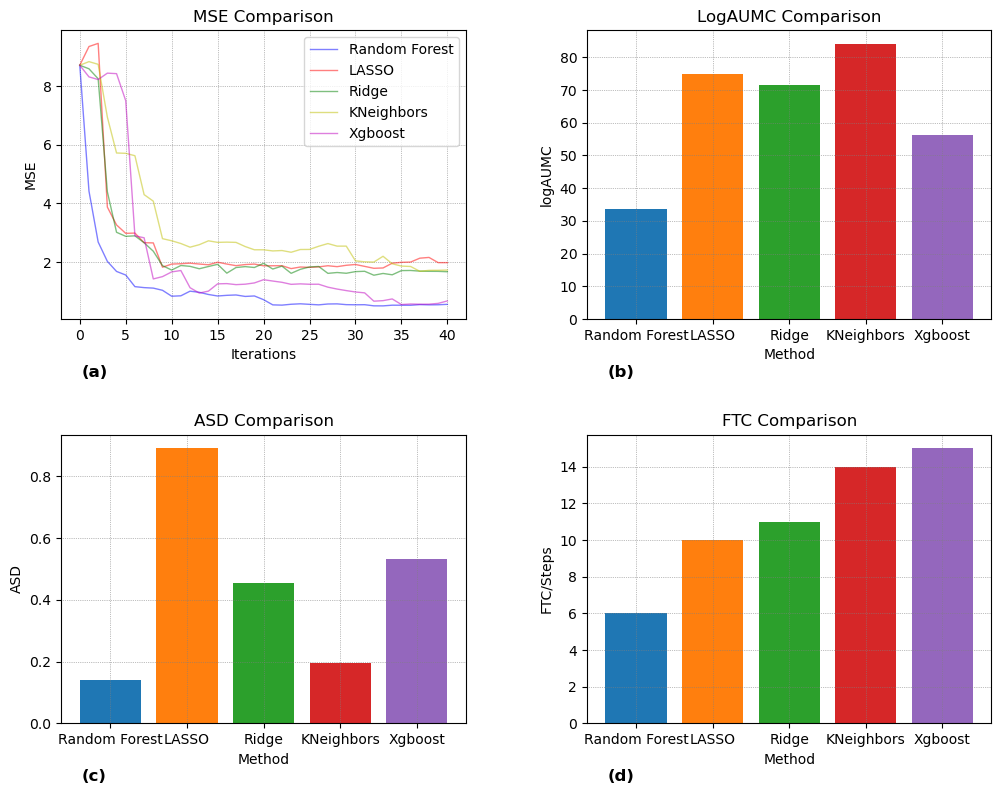

In [72]:
%matplotlib inline
import matplotlib.pyplot as plt

# 创建画布，设置子图大小和间距
fig = plt.figure(figsize=(12, 9))
gs = fig.add_gridspec(2, 2, hspace=0.4, wspace=0.3)

# 第1个子图
ax1 = fig.add_subplot(gs[0, 0])
number=np.arange(0,41)
ax1.plot(number, mean_squared_error_list[0:50], 'b-', alpha=0.5, linewidth=1, label='Random Forest')
ax1.plot(number, L1_mean_squared_error_list[0:50], 'r-', alpha=0.5, linewidth=1, label='LASSO')
ax1.plot(number, L2_mean_squared_error_list[0:50], 'g-', alpha=0.5, linewidth=1, label='Ridge')
ax1.plot(number, KN_mean_squared_error_list[0:50], 'y-', alpha=0.5, linewidth=1, label='KNeighbors')
ax1.plot(number, xgb_mean_squared_error_list[0:50], 'm-', alpha=0.5, linewidth=1, label='Xgboost')
ax1.legend()  #显示上面的label
ax1.set_xlabel('Iterations') #x_label
ax1.set_ylabel('MSE')#y_label
ax1.set_title('MSE Comparison')
ax1.text(0.05, -0.2, "(a)", transform=ax1.transAxes, fontweight="bold", fontsize=12)

# 第2个子图
ax2 = fig.add_subplot(gs[0, 1])
ax2.bar(method_reg, logAUC_reg, color=colors)
ax2.set_xlabel('Method')
ax2.set_ylabel('logAUMC')
ax2.set_title('LogAUMC Comparison')
ax2.text(0.05, -0.2, "(b)", transform=ax2.transAxes, fontweight="bold", fontsize=12)

# 第3个子图
ax3 = fig.add_subplot(gs[1, 0])
ax3.bar(method_reg, ASD_reg, color=colors)
ax3.set_xlabel('Method')
ax3.set_ylabel('ASD')
ax3.set_title('ASD Comparison')
ax3.text(0.05, -0.2, "(c)", transform=ax3.transAxes, fontweight="bold", fontsize=12)

# 第4个子图
ax4 = fig.add_subplot(gs[1, 1])
ax4.bar(method_reg, FTC_reg, color=colors)
ax4.set_xlabel('Method')
ax4.set_ylabel('FTC/Steps')
ax4.set_title('FTC Comparison')
ax4.text(0.05, -0.2, "(d)", transform=ax4.transAxes, fontweight="bold", fontsize=12)



# 设置所有子图的网格线
for ax in [ax1, ax2, ax3, ax4]:
    ax.grid(color='gray', linestyle=':', linewidth=0.5)

# 显示所有子图
plt.show()
